This notebook is influenced by Tensorflow's API found here: https://www.tensorflow.org/tutorials/structured_data/time_series#recurrent_neural_network

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
df = pd.read_csv('/workspaces/Datathon2023/dataset/SPD_Crime_Data__2008-Present.csv')

#make offense start date time a datetime object
date_time = pd.to_datetime(df['Offense Start DateTime'], format='%m/%d/%Y %H:%M:%S %p')
df['start_date_time'] = date_time

#only keep the rows that have a offense start date more than 2008
df = df[df['start_date_time'] >= '2008-01-01']

df = df.set_index('start_date_time')
df = df.groupby([pd.Grouper(freq='D'), 'Offense Parent Group']).size().reset_index(name='Count')

# #drop the rows that have a offense start datetime
# df = df.dropna(subset=['Offense Start DateTime'])

# date_time = pd.to_datetime(df.pop('Offense Start DateTime'), format='%m/%d/%Y %H:%M:%S %p')

# #get the count of crimes for every Offense Parent Group per day
# df = df.groupby([date_time.dt.date, 'Offense Parent Group']).size().reset_index(name='Count')

In [3]:
df.head()

,start_date_time,Offense Parent Group,Count
0,2008-01-01,ASSAULT OFFENSES,53
1,2008-01-01,BAD CHECKS,4
2,2008-01-01,BURGLARY/BREAKING&ENTERING,18
3,2008-01-01,COUNTERFEITING/FORGERY,2
4,2008-01-01,DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY,29


In [4]:
print(df)

      start_date_time                      Offense Parent Group  Count
0          2008-01-01                          ASSAULT OFFENSES     53
1          2008-01-01                                BAD CHECKS      4
2          2008-01-01                BURGLARY/BREAKING&ENTERING     18
3          2008-01-01                    COUNTERFEITING/FORGERY      2
4          2008-01-01  DESTRUCTION/DAMAGE/VANDALISM OF PROPERTY     29
...               ...                                       ...    ...
86007      2023-02-15                      KIDNAPPING/ABDUCTION      1
86008      2023-02-15                             LARCENY-THEFT     11
86009      2023-02-15                       MOTOR VEHICLE THEFT      8
86010      2023-02-15                  STOLEN PROPERTY OFFENSES      1
86011      2023-02-15                 TRESPASS OF REAL PROPERTY      1

[86012 rows x 3 columns]


In [167]:
OFFENSE_PARENT_GROUP = 'MOTOR VEHICLE THEFT'

In [168]:
df_model = df[df['Offense Parent Group'] == OFFENSE_PARENT_GROUP]

#drop all columns except for date and count
df_model = df_model.drop(columns=['Offense Parent Group'])

n = len(df_model)
train_df = df_model[0:int(n*0.7)]
val_df = df_model[int(n*0.7):int(n*0.9)]
test_df = df_model[int(n*0.9):]

num_features = df_model.shape[1]

print(n)

5525


In [169]:
print(train_df)

      start_date_time  Count
13         2008-01-01     11
31         2008-01-02      9
48         2008-01-03      6
66         2008-01-04      9
78         2008-01-05     13
...               ...    ...
61385      2018-07-29     12
61403      2018-07-30     18
61420      2018-07-31     12
61435      2018-08-01     17
61450      2018-08-02     19

[3867 rows x 2 columns]


In [170]:
#normalize the data for the Count column
train_mean = train_df['Count'].mean()
train_std = train_df['Count'].std()

train_df['Count'] = (train_df['Count'] - train_mean) / train_std
val_df['Count'] = (val_df['Count'] - train_mean) / train_std
test_df['Count'] = (test_df['Count'] - train_mean) / train_std

#make the date column the index
train_df = train_df.set_index('start_date_time')
val_df = val_df.set_index('start_date_time')
test_df = test_df.set_index('start_date_time')

<ipython-input-170-54e04112010d>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['Count'] = (train_df['Count'] - train_mean) / train_std
<ipython-input-170-54e04112010d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df['Count'] = (val_df['Count'] - train_mean) / train_std
<ipython-input-170-54e04112010d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

In [171]:
print(train_df)

                    Count
start_date_time          
2008-01-01       0.044654
2008-01-02      -0.430388
2008-01-03      -1.142951
2008-01-04      -0.430388
2008-01-05       0.519696
...                   ...
2018-07-29       0.282175
2018-07-30       1.707302
2018-07-31       0.282175
2018-08-01       1.469781
2018-08-02       1.944823

[3867 rows x 1 columns]


In [172]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [173]:
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['Count'])
w2

Total window size: 7
Input indices: [0 1 2 3 4 5]
Label indices: [6]
Label column name(s): ['Count']

In [174]:
def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window

In [175]:
# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[10:10+w2.total_window_size]),
                           np.array(train_df[20:20+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 1)
Inputs shape: (3, 6, 1)
Labels shape: (3, 1, 1)


In [176]:
w2.example = example_inputs, example_labels

In [177]:
def plot(self, model=None, plot_col='Count', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Date')

WindowGenerator.plot = plot

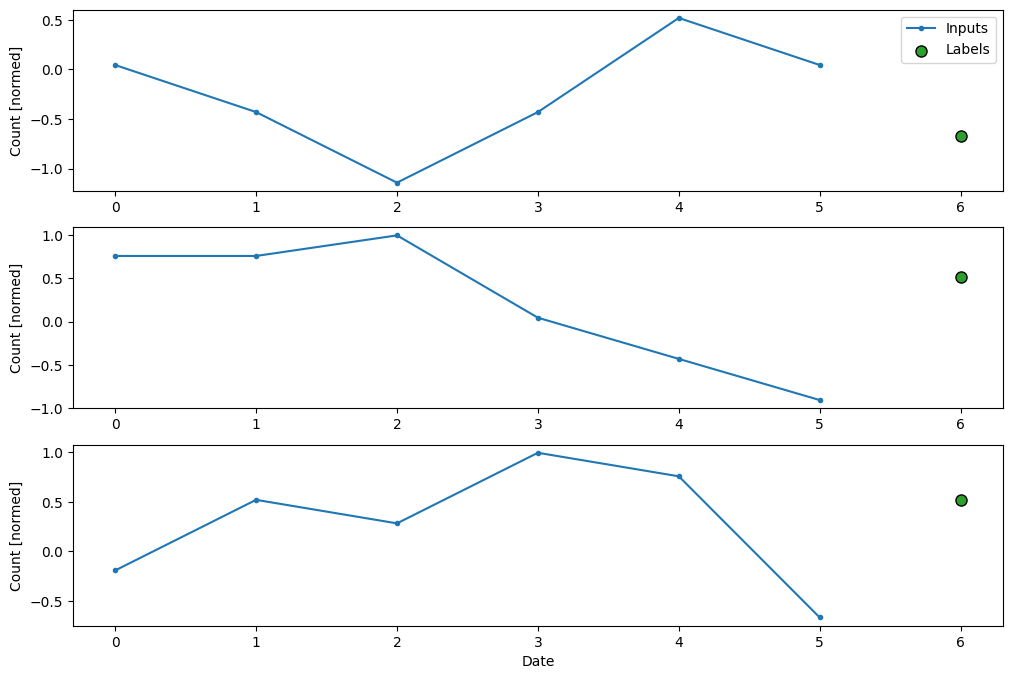

In [178]:
w2.plot()

#show the plot
plt.show()

In [179]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [180]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [181]:
# Each element is an (inputs, label) pair.
w2.train.element_spec

(TensorSpec(shape=(None, 6, 1), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 1, 1), dtype=tf.float32, name=None))

In [182]:
for example_inputs, example_labels in w2.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

Inputs shape (batch, time, features): (32, 6, 1)
Labels shape (batch, time, features): (32, 1, 1)


In [183]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Count'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Count']

Baseline Model (Predict next datapoint based only on currrent data point)

In [184]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['Count'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

35/35 [==============================] - 0s 3ms/step - loss: 1.5267 - mean_absolute_error: 0.9830


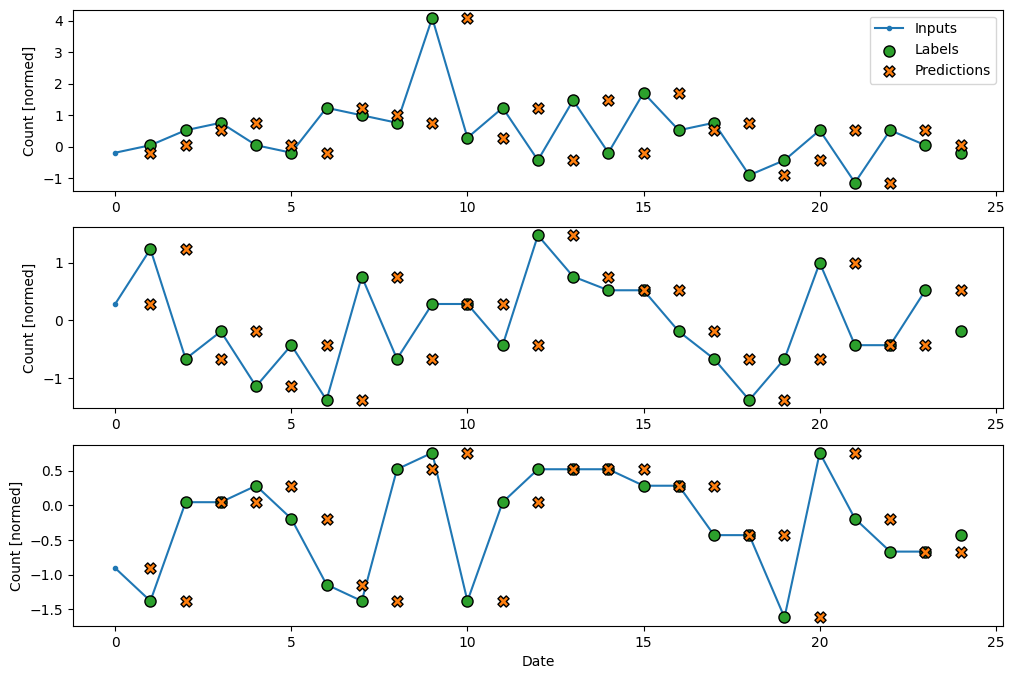

In [185]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Count'])

wide_window
wide_window.plot(baseline)
plt.show()

Linear Model

In [186]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [187]:
MAX_EPOCHS = 100000

def compile_and_fit(model, window, patience=5):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [188]:
history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0)

Epoch 1/100000
121/121 [==============================] - 1s 8ms/step - loss: 1.8252 - mean_absolute_error: 1.0454 - val_loss: 2.1242 - val_mean_absolute_error: 1.1321
Epoch 2/100000
121/121 [==============================] - 1s 8ms/step - loss: 1.6315 - mean_absolute_error: 0.9901 - val_loss: 1.8992 - val_mean_absolute_error: 1.0717
Epoch 3/100000
121/121 [==============================] - 1s 8ms/step - loss: 1.4685 - mean_absolute_error: 0.9405 - val_loss: 1.7135 - val_mean_absolute_error: 1.0187
Epoch 4/100000
121/121 [==============================] - 1s 7ms/step - loss: 1.3341 - mean_absolute_error: 0.8972 - val_loss: 1.5603 - val_mean_absolute_error: 0.9730
Epoch 5/100000
121/121 [==============================] - 1s 7ms/step - loss: 1.2254 - mean_absolute_error: 0.8603 - val_loss: 1.4390 - val_mean_absolute_error: 0.9349
Epoch 6/100000
121/121 [==============================] - 1s 7ms/step - loss: 1.1386 - mean_absolute_error: 0.8306 - val_loss: 1.3387 - val_mean_absolute_error:

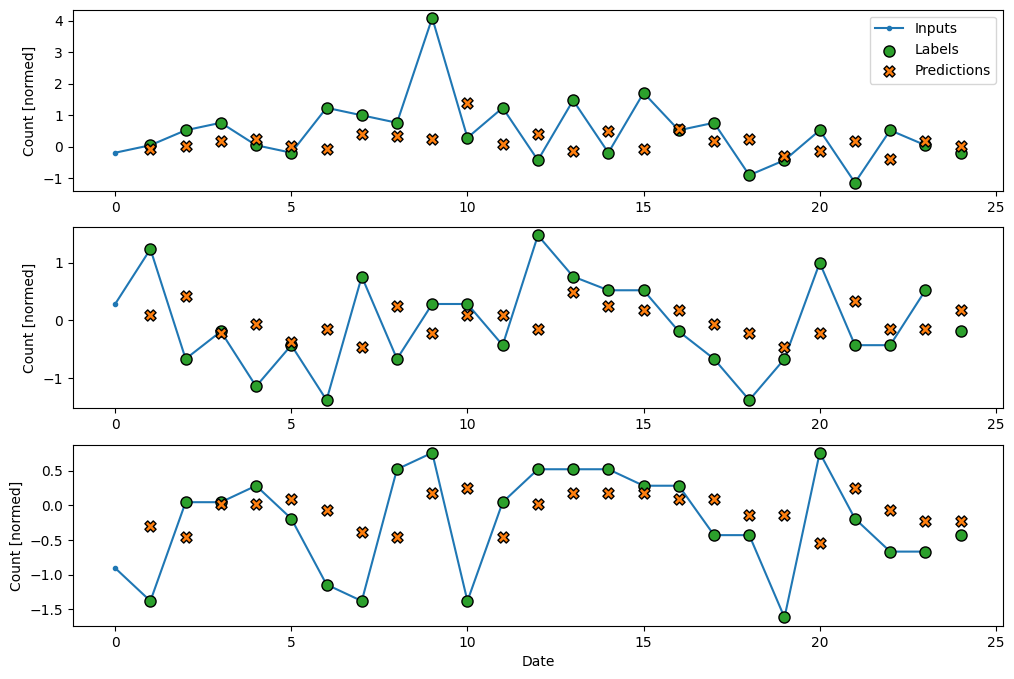

In [189]:
wide_window.plot(linear)
plt.show()

Deeper Single Input Step Model

In [190]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

Epoch 1/100000
121/121 [==============================] - 2s 10ms/step - loss: 0.8984 - mean_absolute_error: 0.7477 - val_loss: 1.0497 - val_mean_absolute_error: 0.8030
Epoch 2/100000
121/121 [==============================] - 1s 10ms/step - loss: 0.8854 - mean_absolute_error: 0.7419 - val_loss: 1.0453 - val_mean_absolute_error: 0.8015
Epoch 3/100000
121/121 [==============================] - 1s 9ms/step - loss: 0.8840 - mean_absolute_error: 0.7404 - val_loss: 1.0582 - val_mean_absolute_error: 0.8056
Epoch 4/100000
121/121 [==============================] - 1s 9ms/step - loss: 0.8839 - mean_absolute_error: 0.7411 - val_loss: 1.0417 - val_mean_absolute_error: 0.8006
Epoch 5/100000
121/121 [==============================] - 1s 10ms/step - loss: 0.8847 - mean_absolute_error: 0.7409 - val_loss: 1.0442 - val_mean_absolute_error: 0.8012
Epoch 6/100000
121/121 [==============================] - 1s 10ms/step - loss: 0.8845 - mean_absolute_error: 0.7415 - val_loss: 1.0540 - val_mean_absolute_er

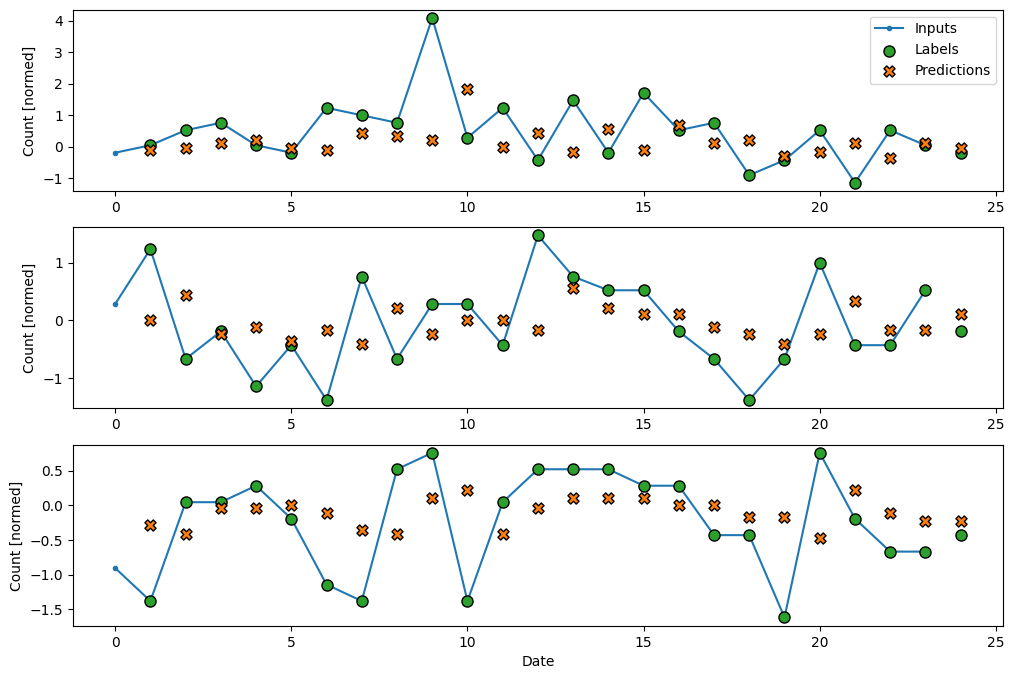

In [191]:
wide_window.plot(dense)
plt.show()

Multi-step Dense

In [192]:
CONV_WIDTH = 14
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Count'])

conv_window

Total window size: 15
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13]
Label indices: [14]
Label column name(s): ['Count']

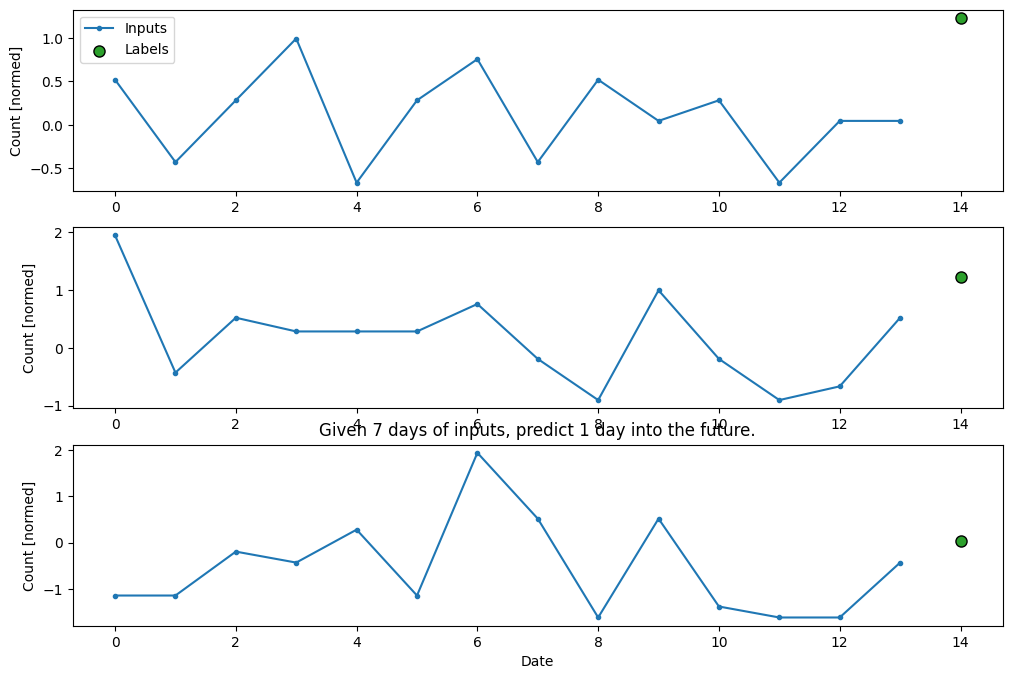

In [193]:
conv_window.plot()
plt.title("Given 7 days of inputs, predict 1 day into the future.")
plt.show()

In [194]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [195]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

35/35 [==============================] - 0s 3ms/step - loss: 0.8996 - mean_absolute_error: 0.7536


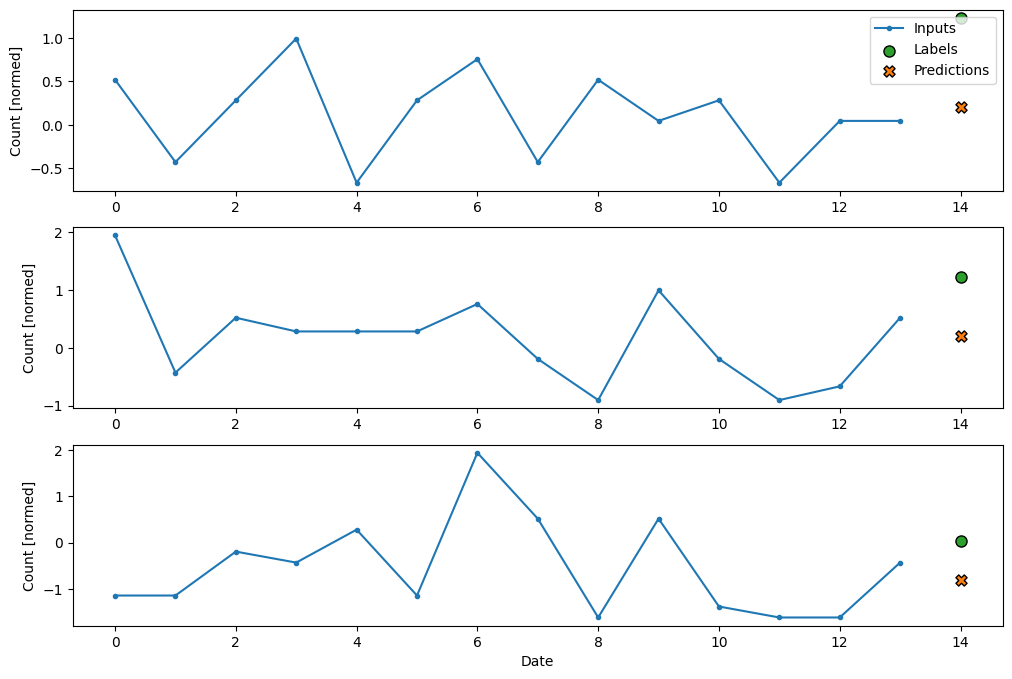

In [196]:
conv_window.plot(multi_step_dense)
plt.show()

CNN

In [197]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [198]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)

35/35 [==============================] - 0s 6ms/step - loss: 0.8940 - mean_absolute_error: 0.7508


In [199]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Count'])

wide_conv_window

Total window size: 38
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36]
Label indices: [14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37]
Label column name(s): ['Count']

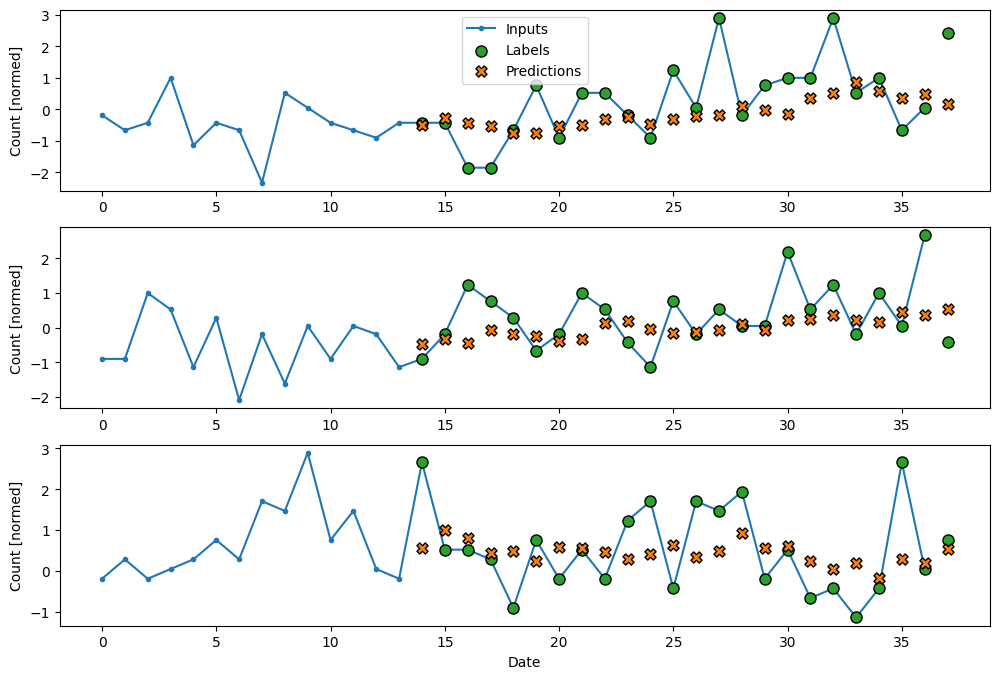

In [200]:
wide_conv_window.plot(conv_model)
plt.show()

RNN

In [201]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(8, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=4),
    tf.keras.layers.Dense(units=1)
])

In [202]:
history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

34/34 [==============================] - 0s 7ms/step - loss: 0.9029 - mean_absolute_error: 0.7569


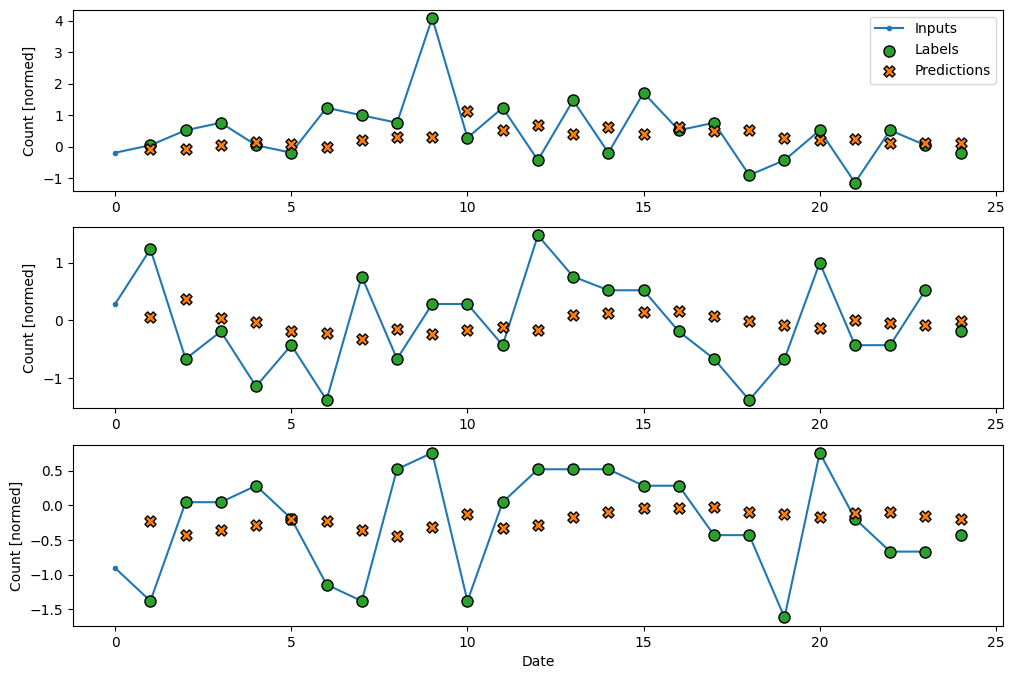

In [203]:
wide_window.plot(lstm_model)
plt.show()

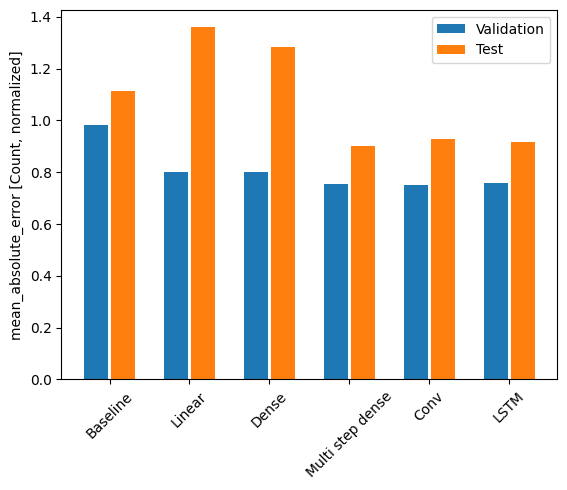

In [204]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')

val_mae = [v[metric_index] for v in list(val_performance.values())]
test_mae = [v[metric_index] for v in list(performance.values())]

plt.ylabel('mean_absolute_error [Count, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()
plt.show()

In [205]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

Baseline    : 1.1140
Linear      : 1.3588
Dense       : 1.2824
Multi step dense: 0.9018
Conv        : 0.9298
LSTM        : 0.9161


Multi Step Methods

In [206]:
OUT_STEPS = 24
multi_window = WindowGenerator(input_width=24,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

Total window size: 48
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47]
Label column name(s): None

Baseline

34/34 [==============================] - 0s 4ms/step - loss: 1.6560 - mean_absolute_error: 1.0252


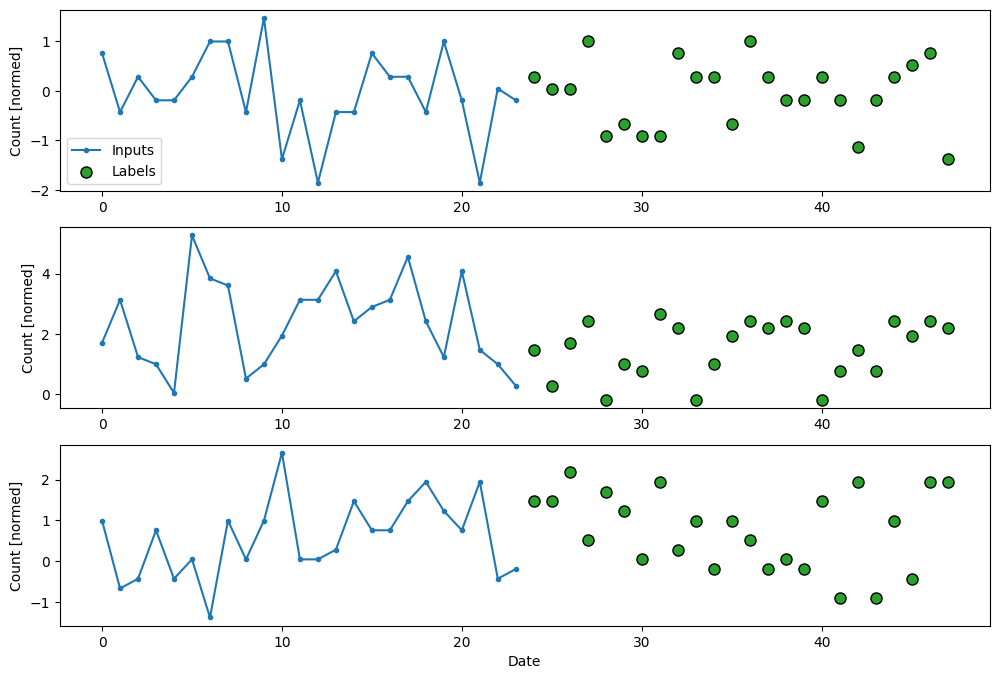

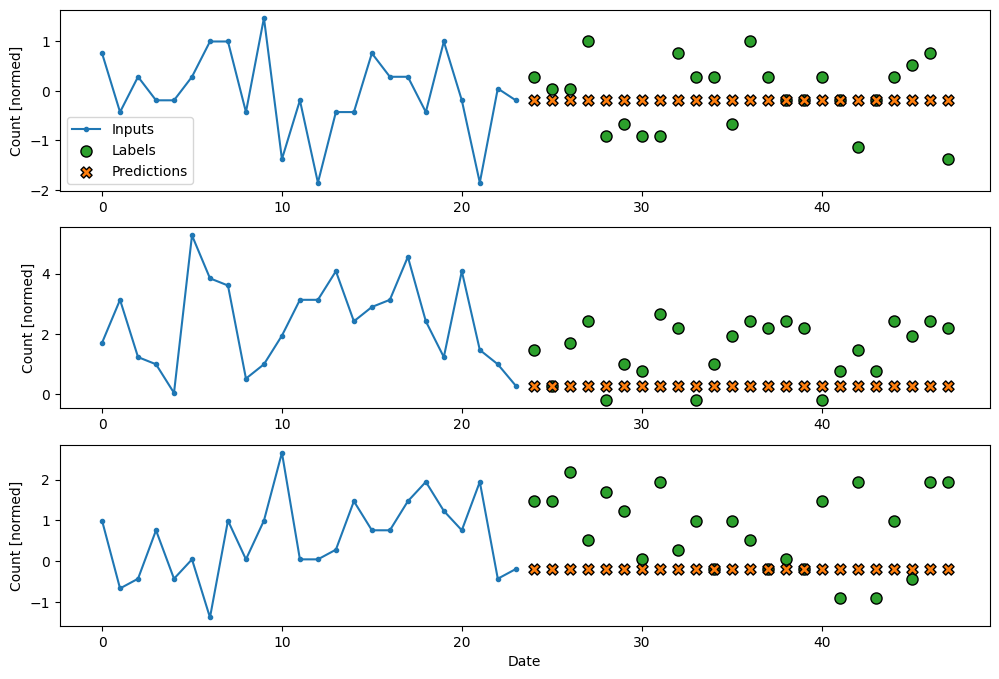

In [207]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                      metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(last_baseline)
plt.show()

34/34 [==============================] - 0s 4ms/step - loss: 1.7682 - mean_absolute_error: 1.0841


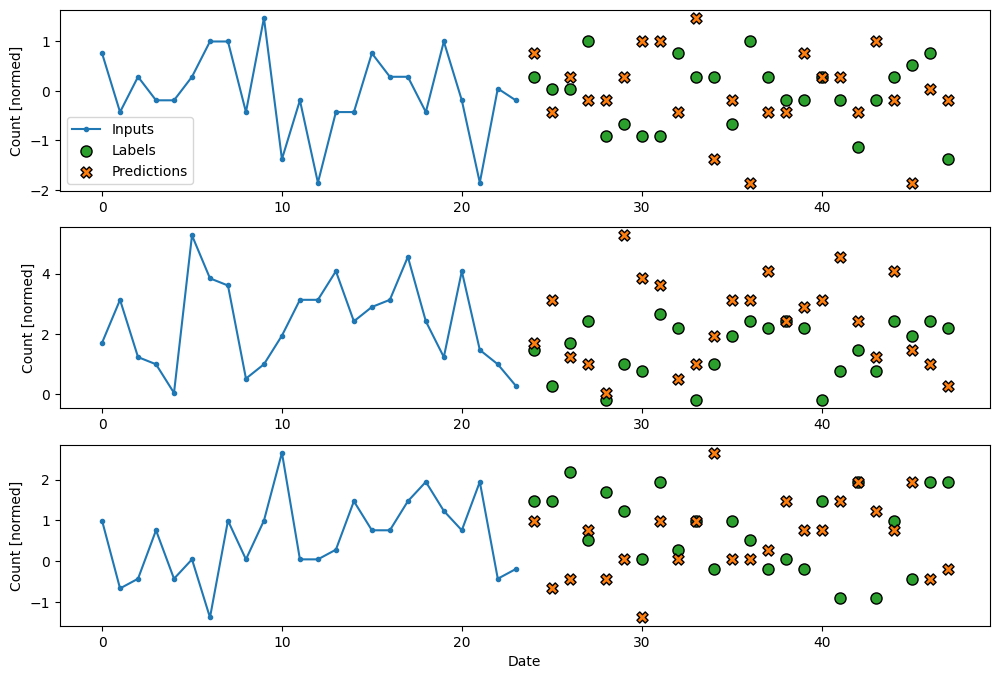

In [208]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                        metrics=[tf.keras.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)
plt.show()

Single Shot

Linear

34/34 [==============================] - 0s 4ms/step - loss: 1.0929 - mean_absolute_error: 0.8241


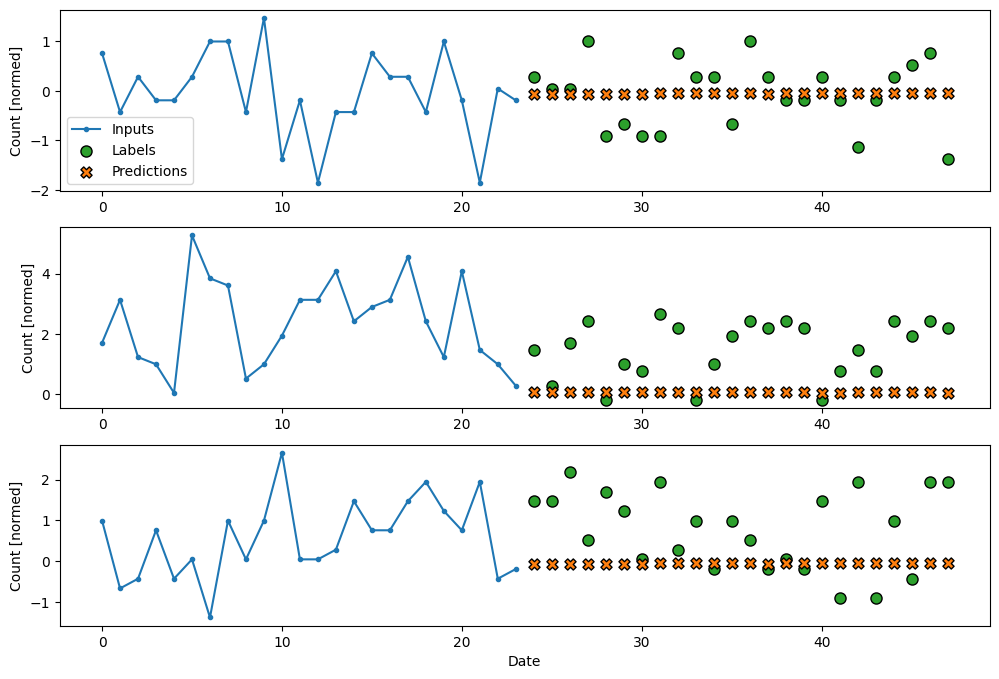

In [209]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)
plt.show()

Dense

34/34 [==============================] - 0s 5ms/step - loss: 1.1063 - mean_absolute_error: 0.8271


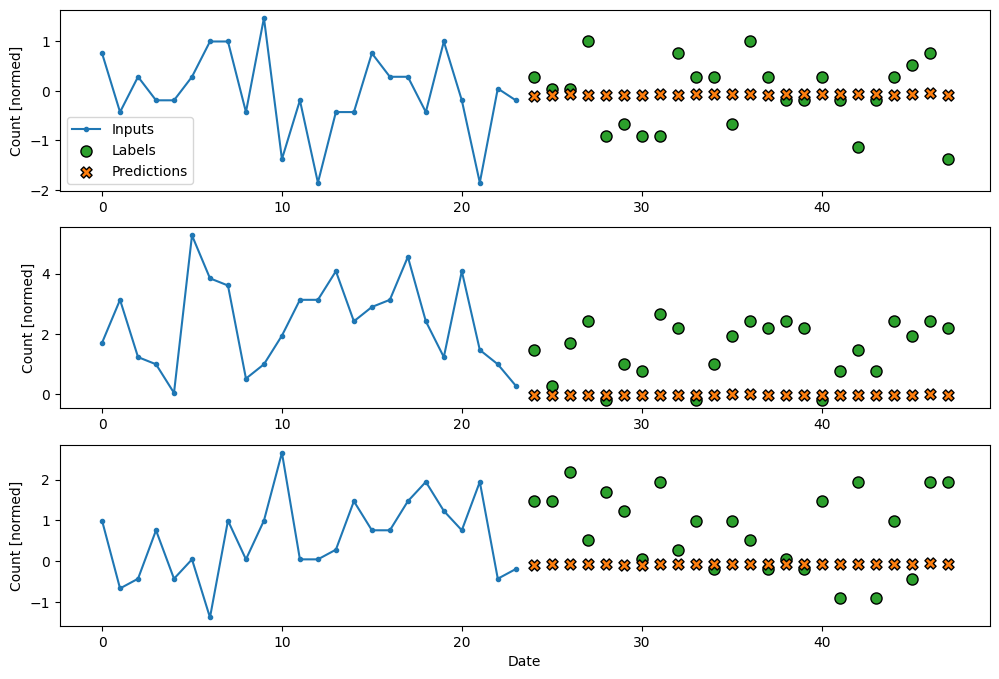

In [210]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)
plt.show()

CNN

34/34 [==============================] - 0s 5ms/step - loss: 1.0086 - mean_absolute_error: 0.7942


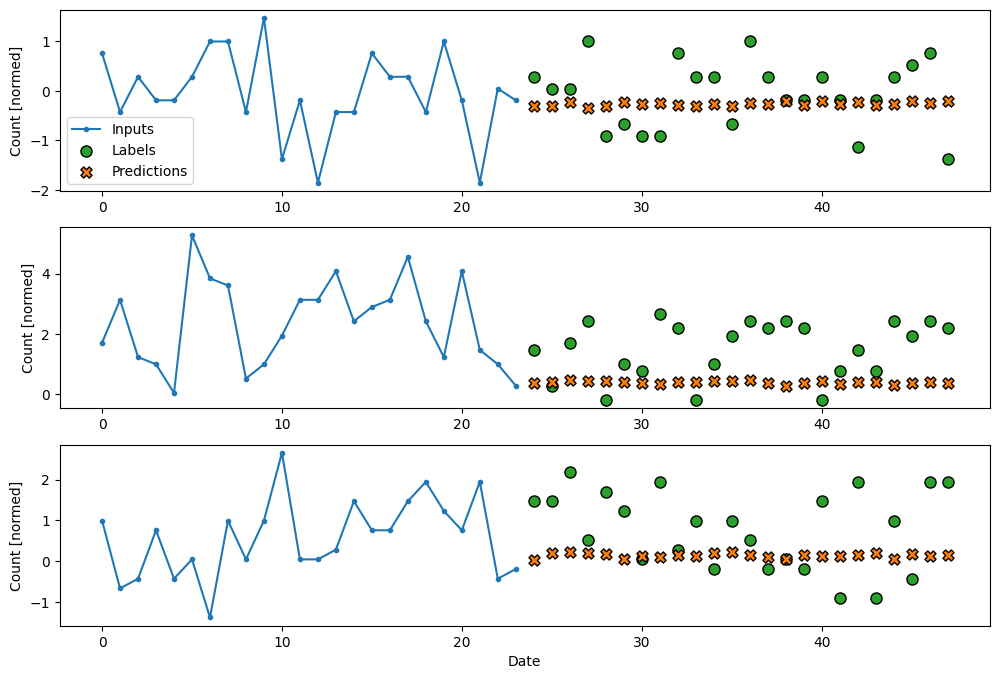

In [211]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)
plt.show()

RNN

34/34 [==============================] - 0s 5ms/step - loss: 0.9115 - mean_absolute_error: 0.7659


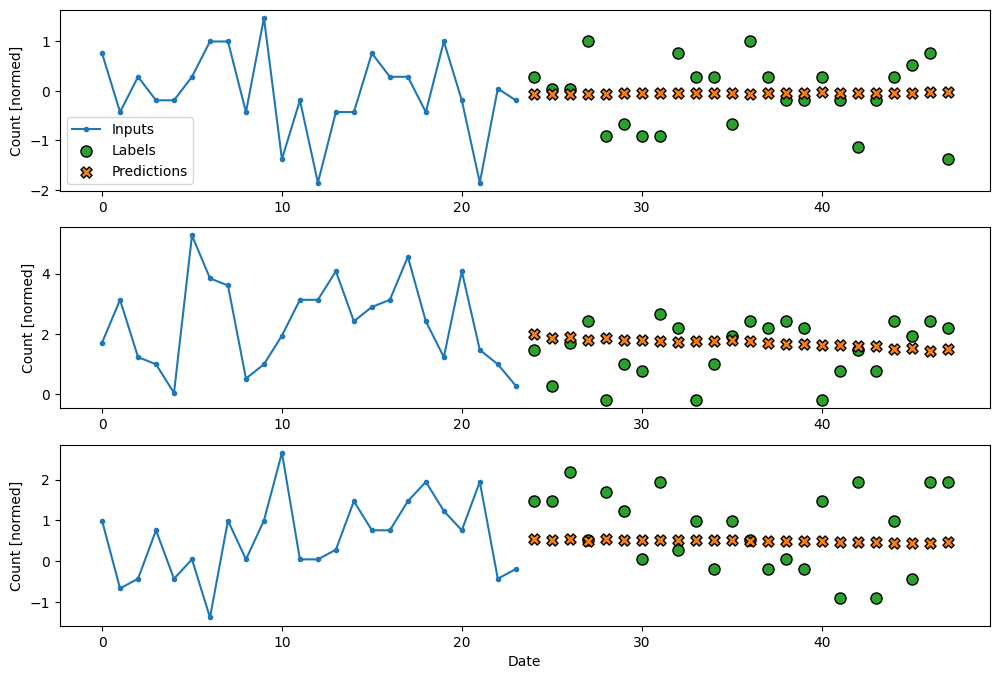

In [212]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units].
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features].
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros()),
    # Shape => [batch, out_steps, features].
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)
plt.show()

Autoregressive Model

In [213]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [214]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

In [215]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

In [216]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

TensorShape([32, 2])

In [217]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the LSTM state.
  prediction, state = self.warmup(inputs)

  # Insert the first prediction.
  predictions.append(prediction)

  # Run the rest of the prediction steps.
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output.
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

In [218]:
# history = compile_and_fit(feedback_model, multi_window)

# IPython.display.clear_output()

# multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
# multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
# multi_window.plot(feedback_model)
# plt.show()

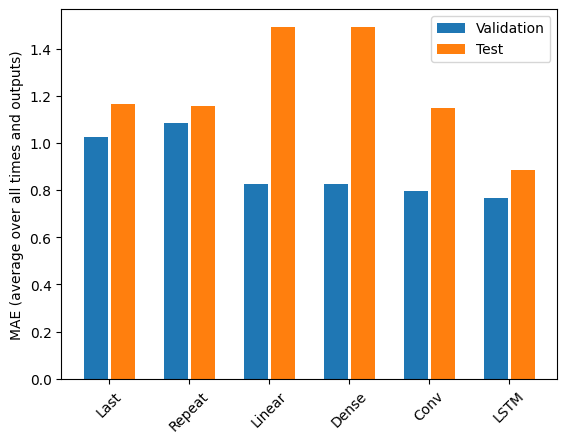

In [219]:
x = np.arange(len(multi_performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()
plt.show()

In [220]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

Last    : 1.1653
Repeat  : 1.1567
Linear  : 1.4929
Dense   : 1.4905
Conv    : 1.1493
LSTM    : 0.8873
